<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Attenuation</div>
  </div>
</div>


Based on our previous example of solving the acoustic wave equation with a finite-difference method, here we will add a viscoaoustic medium to study the effect of attenuation.

**Questions**:<br> 
**How does attenuation affect the shape and velocity of the wave packet?**<br> 
**At which Q values there is no attenuation effect anymore?**<br>



for more notebooks in seismology, see:<br>
https://krischer.github.io/seismo_live_build/tree/index.html


Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [362]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook
from IPython.display import display, clear_output

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.5.1
numpy version:  1.21.5


## Theory

From our previous exercise, we wrote the 1D wave equation for a homogeneous media as
$$
\partial_t^2 u(x,t) = c^2 \partial_x^2 u(x,t)
$$
where we have introduced the wave speed $c = \sqrt{\kappa/\rho}$ (with $\kappa$ being the bulk modulus, and $\rho$ density) for compressional wave propagation. The equation can be derived by using a purely acoustic (or elastic) medium response, where the stress and strain relation is
$$
\sigma(x)  = \kappa \, \partial_x u(x,t)
$$
with strain $\epsilon(x,t) = \frac{1}{2}[ \partial_x u + (\partial_x u(x,t) )^T ] = \partial_x u(x,t)$. Thus, we can write the above wave equation in a more general form as
$$
\begin{align}
\partial_t^2 u(x,t) &=  \frac{1}{\rho} \, \partial_x( \kappa \, \partial_x u(x,t) ) \\
 &=  \frac{1}{\rho} \, \partial_x( \sigma(x) ) 
\end{align}
$$
We see later that in this form, it is easier to compare against the viscoacoustic formulation.

### Viscoacoustic media

Let us introduce attenuation by describing a viscoacoustic medium where the stress-strain relation is written as
$$
\sigma(t) = \int_{-\infty}^t \kappa(t - t') \dot{\epsilon}(t') dt'
$$
where we dropped the dependency on spatial positions for simplification. The bulk modulus $\kappa$ becomes a function of time $\kappa(t)$ with the instantaneous reponse $\kappa(0) = \kappa_u$ being the unrelaxed modulus, and after enough time reaching $\kappa(\infty) = \kappa_r$ the relaxed modulus ($\kappa_u > \kappa_r$).


To solve this, we resort to the standard linear solids and memory variables approach. The constitutive relationship for a standard linear solid is defined by
$$
\dot{\sigma} + \tau_\sigma^{-1} \sigma = \kappa_u ( \dot{\epsilon} + \tau_\epsilon^{-1} \epsilon)
$$
with stress and strain relaxation times $\tau_\sigma$ and $\tau_\epsilon$, respectively ($\tau_\sigma \leq \tau_\epsilon$). The complex modulus is related to the quality factor $Q^{-1} = \frac{\Im(\kappa)}{\Re(\kappa)} = \frac{\kappa_2}{\kappa_1}$. In frequency domain, we define 
$$
\frac{1}{Q} = \frac{\kappa_2}{\kappa_1} = \frac{\omega(\tau_\epsilon - \tau_\sigma)}{1 + \omega^2 \tau_\sigma \tau_\epsilon}
$$
centered around the Debye peak frequency given by the geometrical mean of the stress and strain relaxation times $\omega_{Debye}^{-1} = \sqrt{ \tau_\sigma \tau_\epsilon}$.


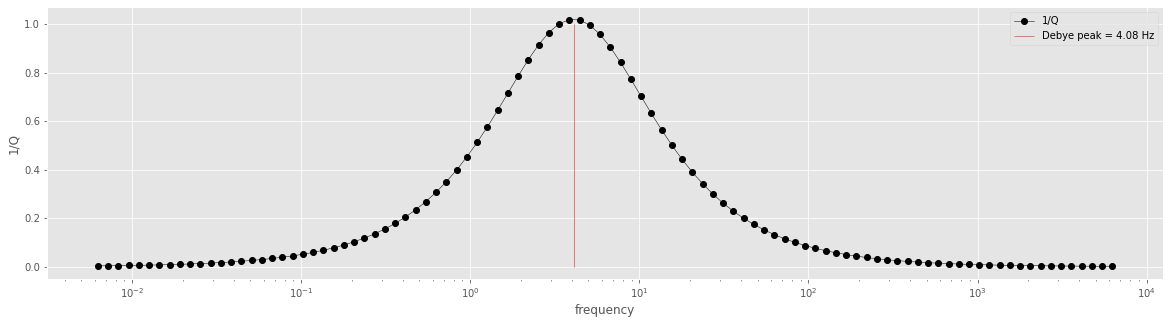

In [363]:
# example: single standard linear solid 

def attenuation_Q_inv(omega,tau_s,tau_e):
    Q_inv = omega * (tau_e - tau_s) / ( 1.0 + omega**2 * tau_s * tau_e )
    return Q_inv

tau_s = 0.1  # stress relaxation time
tau_e = 0.6  # strain relaxation time

# frequencies
freqs = np.logspace(-3,3,100)
freqs = freqs * 2.0 * np.pi    # angular frequencies

# Debye peak
f_peak = 1.0/np.sqrt(tau_s * tau_e)

# plot
plt.plot(freqs,attenuation_Q_inv(freqs,tau_s,tau_e), marker='o', color='black', label='1/Q')
plt.vlines(f_peak,ymin=0.0,ymax=1.0,color='red',label="Debye peak = {:2.2f} Hz".format(f_peak))
plt.xscale('log'); plt.xlabel('frequency'); plt.ylabel('1/Q')
plt.legend()
plt.show()



We could now add more standard linear solids at different Debye peak frequencies to be summed up for $Q^{-1}$. This would broaden up the Q-spectrum to model a flat $Q^{-1}$ value over a broader frequency range. For simplification, we only consider a single solid mechanism from here on.


In time domain, we express the bulk modulus as
$$
\kappa(t) = \kappa_r [ 1 - (1 - \frac{\tau_\epsilon}{\tau_\sigma} ) e^{- t/\tau_\sigma}] \,\, , t \geq 0
$$
where we see that $\kappa(0) = \kappa_u = \kappa_r \frac{\tau_\epsilon}{\tau_\sigma}$. The modulus defect is defined as $\delta \kappa = \kappa_u - \kappa_r = \kappa_r(\frac{\tau_\epsilon}{\tau_\sigma} - 1)$.


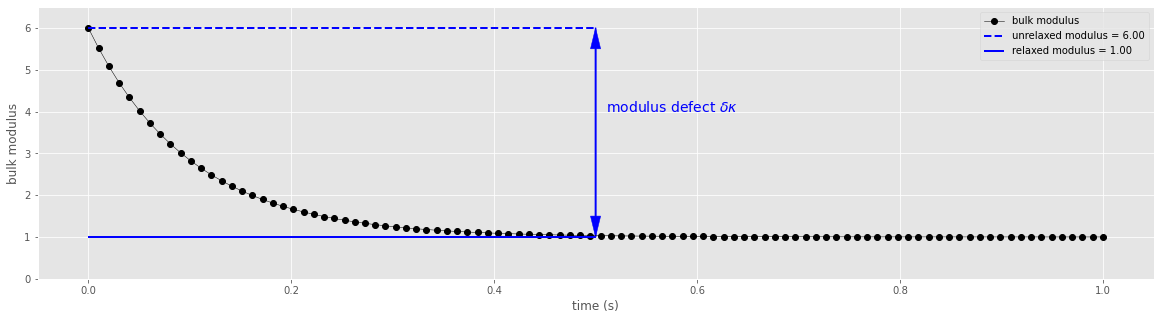

In [364]:
#example: bulk modulus as a function of time
def bulk_relaxation_function(t,kappa_r,tau_s,tau_e):
    kappa = kappa_r * ( 1.0 - (1.0 - tau_e/tau_s) * np.exp(-t / tau_s) )
    return kappa

kappa_r = 1.0  # relaxed modulus

# unrelaxed modulus
kappa_u = kappa_r * tau_e/tau_s

# times
time_t = np.linspace(0.0,1.0,100)

# plot
plt.plot(time_t,bulk_relaxation_function(time_t,kappa_r,tau_s,tau_e), marker='o', color='black', label='bulk modulus')
plt.hlines(kappa_u,xmin=0.0,xmax=0.5,color='blue',linestyle='dashed',linewidth=2,label="unrelaxed modulus = {:2.2f}".format(kappa_u))
plt.hlines(kappa_r,xmin=0.0,xmax=0.5,color='blue',linewidth=2,label="relaxed modulus = {:2.2f}".format(kappa_r))
plt.xlabel('time (s)'); plt.ylim(0.0,kappa_u+0.5); plt.ylabel('bulk modulus')
plt.arrow(0.5,kappa_r,0.0,(kappa_u-kappa_r),color='blue',length_includes_head=True,head_width=0.01,head_length=0.5)
plt.arrow(0.5,kappa_u,0.0,-(kappa_u-kappa_r),color='blue',length_includes_head=True,head_width=0.01,head_length=0.5)
plt.text(0.51,4.0,"modulus defect $\delta \kappa$", color='blue', fontsize=14)
plt.legend()
plt.show()

The constitutive relationship for the standard linear solid becomes
$$
\sigma(t) = \kappa_u \epsilon(t) - R(t)
$$
with the memory variable
$$
R(t) = \int_{-\infty}^t e^{-(t - t')/\tau_\sigma} \epsilon(t') dt' \frac{\delta \kappa}{\tau_\sigma}
$$
using the modulus defect $\delta \kappa$. We further find that the memory variable has to satify the differential equation
$$
\partial_t R(t) = - \frac{R(t)}{\tau_\sigma} + \epsilon \frac{\delta \kappa}{\tau_\sigma}
$$
which can be solved numerically for example by an Euler scheme.

The equation of motion for our viscoacoustic medium is now
$$
\begin{align}
\partial_t^2 u(x,t) &=  \frac{1}{\rho} \partial_x [ \sigma(t) ] \\
&=  \frac{1}{\rho} \partial_x [ \kappa_u \epsilon(x,t) - R(t) ] \\
&=  \frac{1}{\rho} \partial_x [ \kappa_u \partial_x u(x,t) - R(t) ]
\end{align}
$$
where we need to additionally solve
$$
\partial_t R(t) = - \frac{R(t)}{\tau_\sigma} + \epsilon \frac{\delta \kappa}{\tau_\sigma}
$$
The memory variables can be seen as a modification of Hooke's stress to introduce the viscous behavior of the medium, when the elastic behavior would be defined by its unrelaxed modulus $\kappa_u$.



### Discretization

We use the finite-difference method as in the previous example to solve the wave equation (see [example notebook on numerical methods](https://github.com/danielpeter/teaching-seismic-waves/blob/master/7_Numerical_methods/exercise/exercise_numerical_methods.ipynb)). With the discretization for space $x_i = i * \Delta x$ and time $t^n = n * \Delta t$ and the central-difference schemes for both first- and second-order derivatives:
$$
\begin{align}
\partial_t^2 u(x,t) \sim \frac{u_i^{n+1} - 2 u_i^n + u_i^{n-1}}{\Delta t^2}\\
\partial_x \sigma(x,t) \sim \frac{\sigma_{i+1}^n - \sigma_{i-1}^n}{2 \Delta x}
\end{align}
$$
the (viscoacoustic) wave equation in its discretized form becomes
$$
\frac{u_i^{n+1} - 2 u_i^n + u_i^{n-1}}{\Delta t^2} = \frac{1}{\rho} \frac{\sigma_{i+1}^n - \sigma_{i-1}^n}{2 \Delta x}
$$


The displacement at time $t^n + \Delta t$ can therefore be written as
$$
u_i^{n+1} = 2 u_i^n - u_i^{n-1} + \Delta t^2 \frac{1}{\rho} \frac{\sigma_{i+1}^n - \sigma_{i-1}^n}{2 \Delta x} 
$$


To compute the modified stresses 
$$\sigma = \kappa_u \partial_x u(x,t) - R(t)
$$
in its discretized form 
$$
\sigma_i^n = \kappa_u \frac{u_{i+1}^n - u_{i-1}^n}{2 \Delta x} - R_i^n
$$
we must also solve the equation for the memory variable $R$. 

For such a first-order ordinary differential equation, 
$$
\partial_t R(t) = f(t,R(t)) \,, R(t_0) = R^0
$$
we use the (forward) Euler method to approximate $R$ at time $t_n + \Delta t$
$$
R^{n+1} = R^n + \Delta t f(t^n, R^n)
$$


In our case, the function $f(t,R(t)) = - \frac{R(t)}{\tau_\sigma} + \epsilon \frac{\delta \kappa}{\tau_\sigma}$ with strain $\epsilon(x,t) = \partial_x u(x,t)$, modulus defect $\delta \kappa = \kappa_r (\frac{\tau_\epsilon}{\tau_\sigma} - 1)$, and the initial condition $R(t_0) = R(0) = 0$.


Let's calculate this now...



## 1. Model

We first specify a discretization of the model.<br>



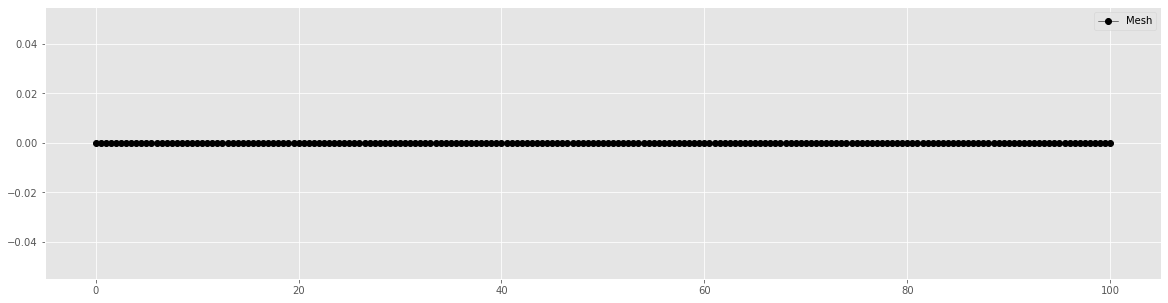

In [365]:
# meshing parameters
dx = 0.5                        # grid size
x = np.arange(0,100.0+dx/2,dx)  # coordinates of grid points: 0-100
nx = len(x)                     # number of grid points

# plot
plt.plot(x, np.zeros(nx), marker='o', color='black', label='Mesh')
plt.legend()
plt.show()

In [366]:
## material properties
# note: we define now a viscoacoustic material, where we provide velocities or moduli at a given reference frequency,
#       together with Q values. 
#       We should also specify, if the velocities or moduli are the relaxed or unrelaxed ones:
#       here, we will provide them as being the unrelaxed ones 
#       (in which case attenuation will slow down velocities as kappa_u > kappa_r)
rho = np.ones(nx)            # density = 1 (kg/m^3)
kappa = np.ones(nx) * 1000   # bulk modulus = 1 kPa = 1000 Pa = 1000 N/m^2 = 1000 kg/(m s^2)

Q = np.ones(nx) * 10         # Q quality factor
reference_f0 = 1.0           # reference frequency at 1 Hz

c  = np.sqrt(kappa/rho)      # wavespeed (used for purely acoustic analytical solution) in m/s

With the given material definition, we can calculate the corresponding relaxation times of the standard linear solid. Having specified $Q$ and reference frequency $\omega_0$, the relaxation times for our single solid can be found. Usually one would use multiple solids, and modeling a flat Q-curve within a certain frequency band becomes an optimization problem to find the best fitting relaxation times. 

#### Minimum wavelength 
Before we determine the position of our standard linear solid, i.e., the Debye peak frequency, let us quickly look at the frequency range of our numerical simulation. The minimum wavelength is determined by the grid spacing and the minimum number of grid points per wavelength we allow. For a finite-differences scheme like ours, a minimum of ~5-10 grid points per wavelength should be taken. The maximum wavelength is given by the full extent of our model. These wavelengths will determine the minimum and maximum periods, and frequency range of our simulation.

In [367]:
def determine_frequency_range(dx,nx,c):
    # minimum wavelength
    lambda_min = dx * (10 - 1)    # to have 10 grid points per wavelength

    # maximum wavelength
    lambda_max = dx * (nx - 1)    # to match full model length

    # wave speed
    c_const = c[0]                # we have a constant material, but in general would use here the fastest wave velocity
                                  # for the estimation

    # period range
    T_min = lambda_min / c_const
    T_max = lambda_max / c_const

    # frequency range
    f_max = 1.0 / T_min
    f_min = 1.0 / T_max

    # angular frequency range
    omega_max = 2.0 * np.pi * f_max
    omega_min = 2.0 * np.pi * f_min

    print("wave speed              : {:3.2f} (m/s)".format(c_const))
    print("wavelength              : min/max = {} / {} (m)".format(lambda_min,lambda_max))
    print("period  range           : min/max = {:2.2f} / {:2.2f} (s)".format(T_min,T_max))
    print("")
    print("frequency range         : min/max = {:2.2f} / {:2.2f} (Hz)".format(f_min,f_max))
    print("angular frequency range : min/max = {:2.2f} / {:2.2f} (Hz)".format(omega_min,omega_max))
    print("")


    # center frequency at the logarithmic mean (will determine the Debye peak frequency)
    f_center = 10.0**( (np.log10(f_min) + np.log10(f_max))/2.0 )

    omega_center = 2.0 * np.pi * f_center

    print("center frequency        : min/max = {:2.2f} (Hz)".format(f_center))
    print("center angular frequency: min/max = {:2.2f} (Hz)".format(omega_center))

    print("")
    
    return omega_center

# gets center frequency    
omega_center = determine_frequency_range(dx,nx,c)


wave speed              : 31.62 (m/s)
wavelength              : min/max = 4.5 / 100.0 (m)
period  range           : min/max = 0.14 / 3.16 (s)

frequency range         : min/max = 0.32 / 7.03 (Hz)
angular frequency range : min/max = 1.99 / 44.15 (Hz)

center frequency        : min/max = 1.49 (Hz)
center angular frequency: min/max = 9.37 (Hz)



This center frequency is very close to the reference frequency of the model. Often, the simulation frequency range can be centered far away from the reference. 

To model attenuation with the standard linear solid approach, we will position the solids around this center frequency of the simulation to mimick the flat Q-absorbtion band within this relevant frequency range. In our example, we use only a single standard linear solid and thus use the center frequency directly as the Debye peak frequency for the solid.

It now becomes practical to shift the moduli first from the reference frequency $\omega_0$ of the model definition to the center frequency using the scaling relation for (elastic) moduli:
$$
\kappa(\omega) = \kappa_0 [ 1 + \frac{2}{\pi} \frac{1}{Q} ln(\frac{\omega}{\omega_0}) ]
$$
Let's quickly do that.


In [368]:
def shift_modulus(kappa,omega_center,reference_f0,Q):
    # reference angular frequency (of our model definition)
    omega_0 = reference_f0 * 2.0 * np.pi

    # shifts modulus to center frequency
    kappa_shifted = kappa * ( 1.0 + 2.0/np.pi * 1.0 / Q * np.log(omega_center / omega_0) )

    print("reference modulus                    : kappa = {:2.5f}".format(kappa[0]))
    print("shifted modulus (to center frequency): kappa = {:2.5f}".format(kappa_shifted[0]))

    return kappa_shifted

# gets shifted modulus
kappa_shifted = shift_modulus(kappa,omega_center,reference_f0,Q)


reference modulus                    : kappa = 1000.00000
shifted modulus (to center frequency): kappa = 1025.41729


## 2. Attenuation mechanism

#### Relaxation times of the standard linear solid(s)
In our example, we position our standard linear solid at the Debye peak frequency, which gives a relation to the stress and strain relaxation times:
$$
\omega_{Debye}^{-1} = \sqrt{ \tau_\sigma \tau_\epsilon }
$$
Furthermore, for our single solid we defined
$$
\frac{1}{Q} = \frac{\omega(\tau_\epsilon - \tau_\sigma)}{1 + \omega^2 \tau_\sigma \tau_\epsilon}
$$
Now solving for $\tau_\epsilon$ and $\tau_\sigma$ at the Debye frequency, we can use the two equations above and rewrite
$$
\tau_\sigma = \frac{1}{\omega_{Debye}^2 \tau_\epsilon}
$$
and
$$
\begin{align}
\frac{1}{Q} &= \frac{\omega_{Debye}(\tau_\epsilon - \tau_\sigma)}{1 + \omega_{Debye}^2 \tau_\sigma \tau_\epsilon} \\
\frac{1}{Q} &= \frac{\omega_{Debye}(\tau_\epsilon - \frac{1}{\omega_{Debye}^2 \tau_\epsilon})}{1 + \omega_{Debye}^2 \frac{1}{\omega_{Debye}^2 \tau_\epsilon} \tau_\epsilon} \\
\frac{1}{Q} &= \frac{\omega_{Debye}(\tau_\epsilon - \frac{1}{\omega_{Debye}^2 \tau_\epsilon})}{2} 
\end{align}
$$
After some more algebra, this leads to a quadratic equation for $\tau_\epsilon$ 
$$
\begin{align}
%\frac{\omega_{Debye}^2 \tau_\epsilon^2 - 1}{\omega_{Debye}^2 \tau_\epsilon} &= \frac{2}{Q \omega_{Debye}}  \\
%\frac{\omega_{Debye}^2 \tau_\epsilon^2 - 1}{\tau_\epsilon} &= \frac{2 \omega_{Debye}}{Q}
\omega_{Debye}^2 \tau_\epsilon^2 - \frac{2 \omega_{Debye}}{Q} \tau_\epsilon - 1 &= 0
\end{align}
$$
The quadratic equation has a real solution if the determinant $b^2 - 4 a c \geq 0$ with $a = \omega_{Debye}^2$, $b = -\frac{2 \omega_{Debye}}{Q}$ and $c = -1$, and we will choose the positive solution as the relaxation time. After obtaining the strain relaxation time $\tau_\epsilon$ this way, we can then calculate the corresponding stress relaxation time $\tau_\sigma$.

Note that for multiple standard linear solids, another way to determining the relaxation times is to start selecting the stress relaxation times independently by assigning evenly distributed frequencies over the frequency range of the simulation: $\tau_\sigma^i = \frac{1}{\omega^i}$. Once the stress relaxation times have been chosen, the strain relaxation times will be determined by an optimization problem to obtain the best possible flat Q response over the frequency range of interest.

Let's keep it simple here and determine the strain relaxation time by the quadratic formula:

In [369]:
def determine_relaxation_times(omega_Debye,Q):
    # quadratic equation for strain tau_epsilon
    # strain relaxation time
    a = omega_Debye**2
    b = - 2.0 * omega_Debye / Q[0]
    c = - 1
    det = b**2 - 4.0 * a * c

    tau_1 = (- b + np.sqrt(det))/ ( 2.0 * a)
    tau_2 = (- b - np.sqrt(det))/ ( 2.0 * a)

    print("determinant: det = ",det) 
    print("solutions  : tau_1 = {} and tau_2 = {}".format(tau_1,tau_2))
    print("")

    # sets the strain relaxation time to the positive solution
    if tau_1 > 0.0:
        tau_e = tau_1
    elif tau_2 > 0.0:
        tau_e = tau_2
    else:
        print("no solution found...")
        tau_e = 0.0

    # sets the stress relaxation time
    tau_s = 1.0 / (omega_Debye**2 * tau_e)

    print("strain relaxation time: tau_e = {:2.5f}".format(tau_e))
    print("stress relaxation time: tau_s = {:2.5f}".format(tau_s))
    print("")

    # checks that tau_s < tau_e
    print("checks:")
    if tau_s > tau_e:
        print("  warning - relaxation times invalid, tau_s > tau_e")
    else:
        print("  good - relaxation times tau_s > tau_e")

    # checks corresponding Debye peak
    omega_peak = 1.0 / np.sqrt(tau_s * tau_e)
    print("  Debye peak frequency calculated: ",omega_peak," compared to ",omega_Debye)
    print("")

    # checks with Q_inv (based on tau_e & Debye frequency)
    Q_inv = omega_Debye * (tau_e - 1.0/(omega_Debye**2 * tau_e)) / 2.0
    print("  Q calculated (tau_e & Debye): ",1.0/Q_inv," compared to ",Q[0])

    # checks with the corresponding Q value
    Q_inv = omega_Debye * (tau_e - tau_s)/(1.0 + omega_Debye**2 * tau_s * tau_e)

    print("  Q calculated (tau_e & tau_s & Debye): ",1.0/Q_inv," compared to ",Q[0])
    print("")
    
    return tau_s,tau_e

# positions our standard linear solid at the center frequency
omega_Debye = omega_center

# gets relaxation times
tau_s,tau_e = determine_relaxation_times(omega_Debye,Q)


determinant: det =  354.42846027023114
solutions  : tau_1 = 0.11797331364798695 and tau_2 = -0.09662043734547164

strain relaxation time: tau_e = 0.11797
stress relaxation time: tau_s = 0.09662

checks:
  good - relaxation times tau_s > tau_e
  Debye peak frequency calculated:  9.366419641387635  compared to  9.366419641387635

  Q calculated (tau_e & Debye):  10.000000000000007  compared to  10.0
  Q calculated (tau_e & tau_s & Debye):  10.000000000000005  compared to  10.0



Having the relaxation times $\tau_\sigma$ and $\tau_\epsilon$, and the provided unrelaxed modulus $\kappa_u = \kappa(0) = \kappa_r \frac{\tau_\epsilon}{\tau_\sigma}$, we find that the relaxed modulus is given by
$$
\kappa_r = \kappa_u \frac{\tau_\sigma}{\tau_\epsilon}
$$

In [370]:
def determine_relaxed_modulus(kappa_shifted,tau_s,tau_e):
    # unrelaxed modulus (as defined by model and shifted to frequency range of interest)
    kappa_u = kappa_shifted

    # relaxed modulus 
    kappa_r = kappa_u * tau_s / tau_e

    print("unrelaxed modulus kappa_u = {:5.4f} (Pa)".format(kappa_u[0]))
    print("relaxed   modulus kappa_r = {:5.4f} (Pa)".format(kappa_r[0]))
    print("")

    # checks that kappa_u > kappa_r
    if (kappa_u-kappa_r).any() < 0.0:
        print("warning: kappa_u < kappa_r")

    # modulus defect
    kappa_defect = kappa_u - kappa_r

    print("modulus defect = {:5.4f} (Pa)".format(kappa_defect[0]))
    print("")

    return kappa_u,kappa_r,kappa_defect

# gets un/relaxed modulus and modulus defect
kappa_u,kappa_r,kappa_defect = determine_relaxed_modulus(kappa_shifted,tau_s,tau_e)


unrelaxed modulus kappa_u = 1025.4173 (Pa)
relaxed   modulus kappa_r = 839.8193 (Pa)

modulus defect = 185.5980 (Pa)



## 3. Time stepping

Here we choose a time step size

In [371]:
# timing parameters
FACTOR = 1.0 

dt = FACTOR * np.min(dx**2/c**2)    # time step
dt = np.round(dt,decimals=4)        # round-off 4 digit

T_total = 1.0                      # simulation time
t = np.arange(0,T_total+dt/2,dt)
nt = len(t)

print("time step dt = ",dt)
print("number of time steps nt = ",nt)
print("")



time step dt =  0.0002
number of time steps nt =  5001



## 4. Initial conditions

Let's assign an initial displacement of the form $u(x,0) = \phi(x)$ with $\phi(x) = e^{-\sigma(x-50)}$ where $\sigma = 0.1$:

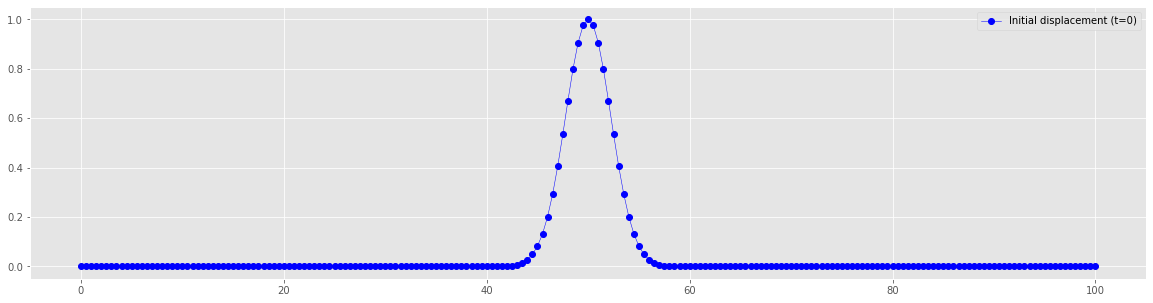

In [372]:
# wavefields
u         = np.zeros(nx)  # displacement at time t^n
u_nminus1 = np.zeros(nx)  #                 time t^{n-1}
u_nplus1  = np.zeros(nx)  #                 time t^{n+1}

u_analytic = np.zeros(nx)  # analytical solution

# stress field
sigma = np.zeros(nx)

# memory variables
R = np.zeros(nx)

# initial displacement function
def phi_function(x):
    # initial displacement
    std = 0.1
    phi = np.exp(-std*(x-50)**2) 
    return phi

# initial condition
def initialize():
    global u,u_nminus1,u_nplus1,sigma,R
    # initial displacement
    u = phi_function(x)
    # same for previous (zero velocity from previous time step)
    u_nminus1 = np.copy(u)
    # same for next (zero velocity for upcoming time step)
    u_nplus1 = np.copy(u)
    # no initial stress
    sigma[:] = 0.0
    # no initial memory
    R[:] = 0.0

initialize()

# plot
plt.plot(x, u, marker='o', color='b', label='Initial displacement (t=0)')
plt.legend()
plt.show()

## 5. Wave propagation
Let's quickly setup helper functions to solve the memory variable update and stress calculations.

In [373]:
# helper function to solve the updated memory variable
def update_R(u,R,kappa_defect,tau_e,tau_s):
    global dx,dt
    ## Euler scheme:
    # R^{n+1} = R^n + \Delta t f(t^n, R^n)
    # and f(t,R(t)) = - \frac{R(t)}{\tau_\sigma} + \epsilon \frac{\delta \kappa}{\tau_\sigma}        
    for i in np.arange(1,nx-1):
        # strain
        eps = (u[i+1]-u[i-1]) / (2.0 * dx)
        # modulus defect \delta \kappa = \kappa_r (\frac{\tau_\epsilon}{\tau_\sigma} - 1)
        #  dmodulus = kappa_r * (tau_e / tau_s - 1.0) 
        # given by kappa_defect
        defect = kappa_defect[i]
        # function f(t,R(t))
        f = - R[i] / tau_s + eps * defect / tau_s
        # memory variable update (Euler scheme)
        R[i] = R[i] + dt * f    
    return R

# helper functions to solve the updated stresses
def compute_stress(u,R,sigma,kappa_u):
    global dx
    ## stress (viscoacoustic)
    # sigma = kappa_u \partial_x u(x,t) - R(t)
    for i in np.arange(1,nx-1):
        sigma_elastic = kappa_u[i] * (u[i+1]-u[i-1]) / (2.0 * dx)
        sigma[i] = sigma_elastic - R[i]
    return sigma
    

Now we're all set and can start propagating waves in our time loop:

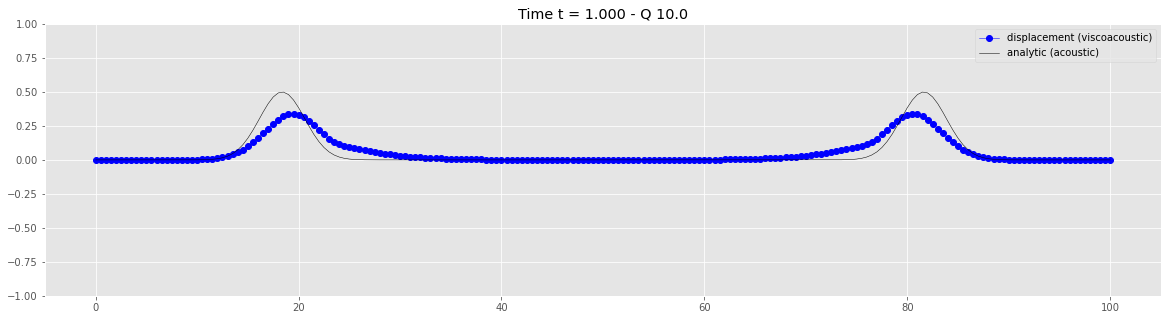

In [374]:
print("starting time loop ... ")
print("")

# initialize
initialize()

# set up plot
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

# time marching
for it in np.arange(0,nt):

    # time scheme
    u_nminus1 = np.copy(u)
    u = np.copy(u_nplus1)

    # computes first the (viscoelastic) stresses 
    sigma = compute_stress(u,R,sigma,kappa_u)
    
    # finite-difference update
    # uses the stress formulation:
    #    u_i^{n+1} = 2 u_i^n - u_i^{n-1} + dt**2 1/rho (sigma_{i+1}^n - sigma_{i-1}^n)/(2 dx)
    for i in np.arange(1,nx-1):        
        u_nplus1[i] = 2*u[i] - u_nminus1[i] + (dt*dt/ rho[i]) * (sigma[i+1]-sigma[i-1]) / (2.0*dx)

    # update memory variables
    # R^{n+1} = R^n + dt f
    R = update_R(u,R,kappa_defect,tau_e,tau_s)
    
    # plot figure
    if (it+1)%50 == 0:
        t_nplus1 = (it+1) * dt
        
        # analytical solution
        for ix in np.arange(len(x)):
            x_pos = ix * dx # position
            f = phi_function(x_pos + c[ix] * t_nplus1)
            g = phi_function(x_pos - c[ix] * t_nplus1)            
            u_analytic[ix] = 1.0/2.0 * ( f + g)
            
        # plotting
        t_nplus1 = np.round(t_nplus1,decimals=4)        # round-off 4 digit
        #print("time step ",it," - time = ",t_nplus1)
        #print("")
        
        # plots displacement  
        clear_output(wait=True)
        plt.title('Time t = {:2.3f} - Q {}'.format(t_nplus1,Q[0]))
        plt.plot(x, u_nplus1, marker='o', color = 'b', label = 'displacement (viscoacoustic)')
        plt.plot(x, u_analytic, color = 'black', label = 'analytic (acoustic)')
        plt.ylim(-1,1)
        plt.legend()
        #plt.show()
        plt.pause(0.01)
        


Now, change the quality factor Q and see what happens...